In [84]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest

from pathlib import Path

In [2]:
# First of all: load data

from zwad.utils import load_data

def feature_file(oid_file):
    parent = oid_file.parent
    if oid_file.name.startswith('oid_'):
        name = oid_file.name.replace('oid_', 'feature_')
    else:
        name = oid_file.name.replace('sid_', 'feature_')
    
    return parent.joinpath(name)
    

datadir = Path('features', 'dr4_new')
sid_extragal_gr = datadir.joinpath('sid_extragal_short_gr_100.dat')
feature_extragal_gr = feature_file(sid_extragal_gr)

fakesdir = Path('features', 'fakes')
sid_fakes = list(fakesdir.glob('oid_*.dat'))
feature_fakes = [feature_file(s) for s in sid_fakes]

sids, features = load_data([sid_extragal_gr] + sid_fakes, [feature_extragal_gr] + feature_fakes)

In [87]:
%%time

# Perform calculations of outliers

isoforest = IsolationForest(n_subsamples=1024, n_trees=1000)
isoforest.fit(features)
scores = isoforest.score_samples(features)
ordered_sids = sids[np.argsort(scores)]
detection_curve = np.cumsum(ordered_sids < 1e10)

CPU times: user 1h 4min 56s, sys: 14.7 s, total: 1h 5min 11s
Wall time: 1min 8s


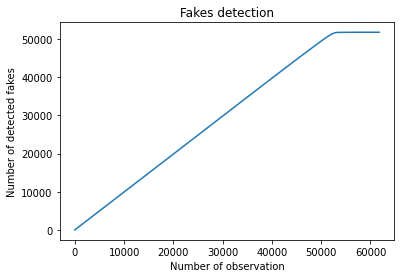

In [88]:
# Plot the detection curve

n_fakes = detection_curve[-1]

plt.plot(detection_curve[:n_fakes+10000])
plt.xlabel('Number of observation')
plt.ylabel('Number of detected fakes')
plt.title('Fakes detection')
pass

In [119]:
n_fakes - detection_curve[60000]

24

In [122]:
n_fakes - detection_curve[1000000]

0

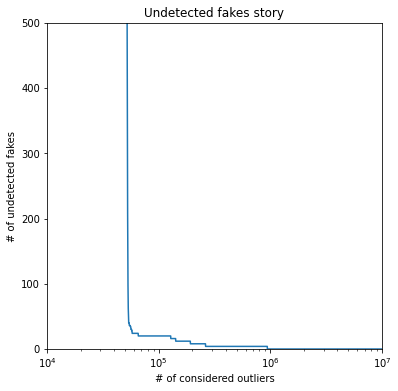

In [125]:
plt.figure(figsize=(6, 6))
plt.title('Undetected fakes story')
plt.plot(np.arange(0, len(detection_curve), 100), n_fakes - detection_curve[::100])
plt.xlabel('# of considered outliers')
plt.xlim(1e4, 1e7)
plt.xscale('log')
plt.ylabel('# of undetected fakes')
plt.ylim(0, 500)
pass

In [66]:
isoforest = IsolationForest(n_subsamples=1024, n_trees=10000)
isoforest.fit(features)
fake_trees = PineForest.filter_trees(isoforest.trees, features[-n_fakes:], np.full(n_fakes, -1), 9000)

In [63]:
def get_most_frequent_roots(trees, n_hits=4):
    bins = np.bincount([tree.__getstate__()['nodes'][0]['feature'] for tree in trees])
    sort_index = np.argsort(bins)[::-1]
    sorted_bins = bins[sort_index]
    index = np.argwhere(sorted_bins >= n_hits).ravel()
    return sort_index[index]

In [72]:
roots = get_most_frequent_roots(fake_trees, n_hits=30)

In [123]:
feature_names = Path('features', 'dr4_new', 'feature_extragal_short_gr_100.name').open('r').read().split('\n')

def plot_feature_histogram(feature):
    values = features[:, feature]
    bins = np.linspace(values.min(), values.max(), 30)

    plt.figure()
    plt.title(f'Feature #{feature}({feature_names[feature]}) histogram')
    plt.hist(values[:-n_fakes], bins=bins, alpha=0.5, label='dr4')
    plt.hist(values[-n_fakes:], bins=bins, alpha=0.5, label='fakes')
    plt.yscale('log')
    plt.legend()

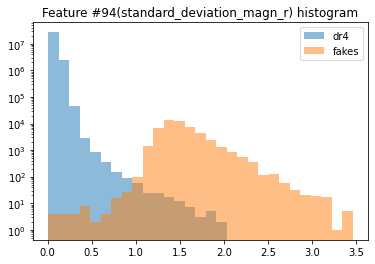

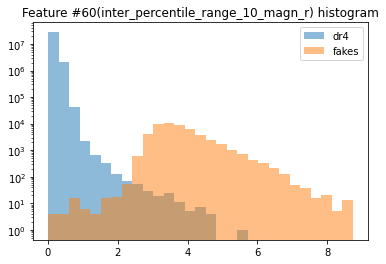

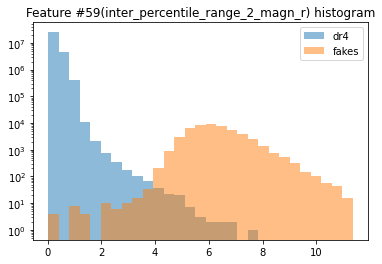

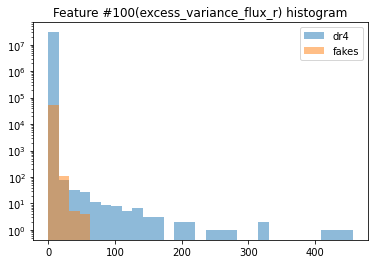

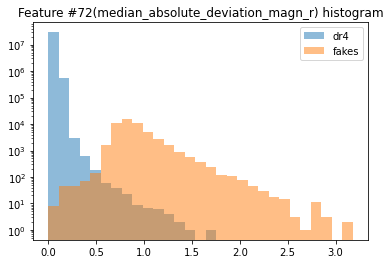

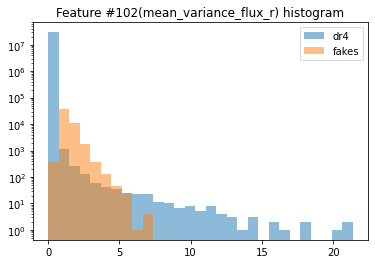

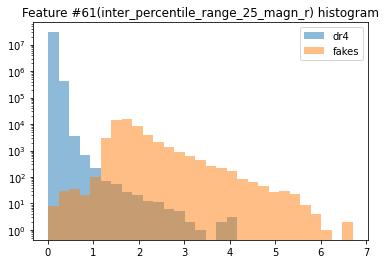

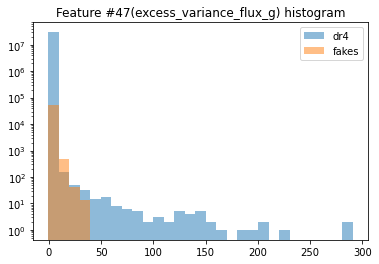

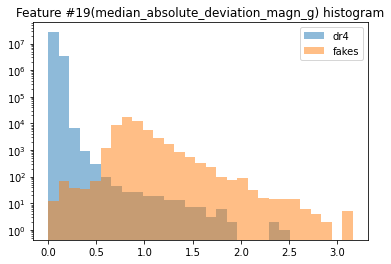

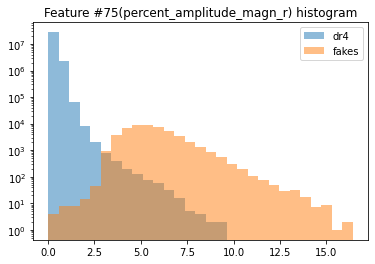

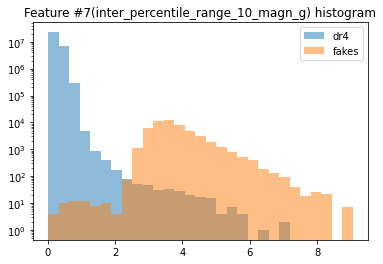

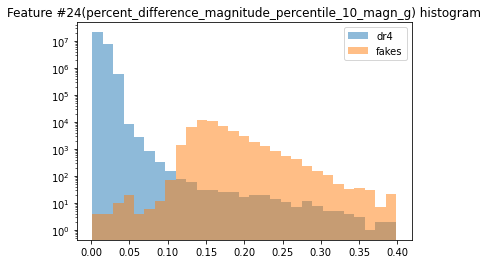

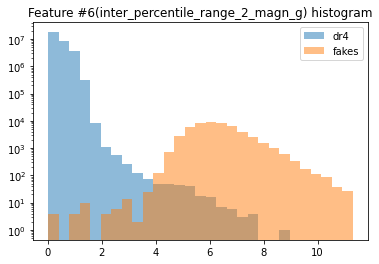

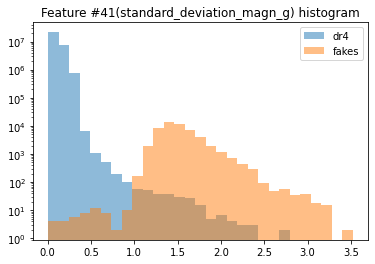

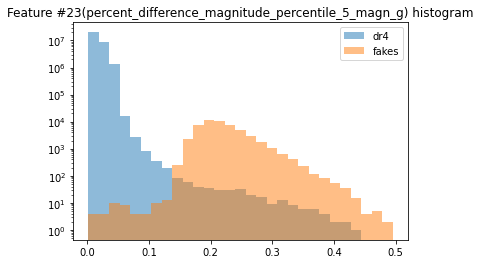

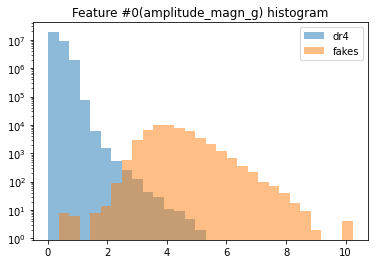

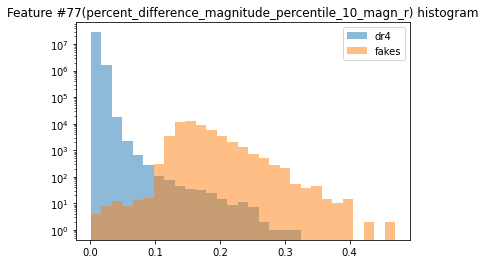

In [124]:
for root in roots:
    plot_feature_histogram(root)
    plt.show()